## 1. Binary Classifier

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, Input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, GaussianNoise, BatchNormalization, concatenate, Cropping2D, ZeroPadding2D, AvgPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from skimage.io import imread
from sklearn.model_selection import train_test_split

from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import gc
import pickle
import datetime

gc.enable()

ship_dir = '../data/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

print(tf.__version__)

2.1.0


In [2]:
# define params for the model
class Params():
    def __init__(self):
        self.batch_size = 128
        self.epochs = 25
        self.image_size = (256, 256)
        
params = Params()

In [3]:
# read the mask data provided by kaggle
seg = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(seg.shape[0], 'masks found')
print(seg['ImageId'].value_counts().shape[0], 'unique images found')
seg.sample()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
186490,ce02844c5.jpg,NaN


In [4]:
# identify images that have a mask (ship identification)
from util import agg_ship_count
train_df = agg_ship_count(pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv')), train_image_dir)
train_df.sample(10)

,ImageId,ship_count,has_ship,class
109987,9237cc654.jpg,0,0,no_ship
126479,a83f05847.jpg,0,0,no_ship
174567,e822d460c.jpg,0,0,no_ship
77537,670be7295.jpg,0,0,no_ship
189163,fb8d2019a.jpg,0,0,no_ship
167602,dee71e926.jpg,0,0,no_ship
101946,878b2057a.jpg,0,0,no_ship
57134,4c2dc7d28.jpg,0,0,no_ship
28007,253c19424.jpg,0,0,no_ship
98574,83253b306.jpg,0,0,no_ship


In [5]:
# Create a validation set by splitting the training data
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.25,
    stratify = train_df['has_ship']
)

print(train_df.shape[0], 'training samples')
print(valid_df.shape[0], 'validation samples')

143466 training samples
47823 validation samples


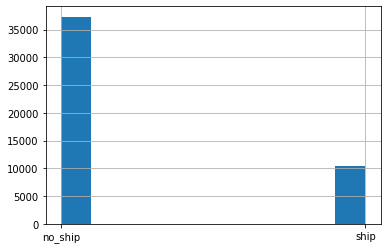

In [6]:
valid_df['class'].hist()

In [7]:
no_ship_count = train_df[train_df['class'] == 'no_ship'].shape[0]
ship_count = train_df[train_df["class"] == 'ship'].shape[0]

print('no_ship count: {}\nship count:     {}'.format(no_ship_count, ship_count))

no_ship count: 111969
ship count:     31497


In [8]:
no_ship_idxs = train_df[train_df['class'] == 'no_ship'].sample(no_ship_count - ship_count - 10000).index
balanced_train_df = train_df.drop(no_ship_idxs, inplace=False)

In [9]:
no_ship_count = balanced_train_df[balanced_train_df['class'] == 'no_ship'].shape[0]
print('balanced no ship count: {}'.format(no_ship_count))

balanced no ship count: 41497


In [10]:
valid_image_generator = ImageDataGenerator(rescale=1./255)
valid_data_gen = valid_image_generator.flow_from_dataframe(
    valid_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True
)

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True
)

train_data_gen = train_image_generator.flow_from_dataframe(
    balanced_train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True
)

Found 47823 validated image filenames belonging to 2 classes.
Found 72994 validated image filenames belonging to 2 classes.


In [11]:
model_ts = str(datetime.datetime.now()).replace(' ', '_')

In [12]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=10e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07,
    name='Adam'
)

In [23]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='binary_summaries', 
    histogram_freq=1, 
    write_graph=True, 
    write_images=True,
    update_freq='epoch', 
    profile_batch=2, 
    embeddings_freq=0,
    embeddings_metadata=None
)

csvLogger = tf.keras.callbacks.CSVLogger(
    'dropout_{}'.format(model_ts), separator=',', append=False
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

reduceLROnPlateautf = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto',
    min_delta=0, 
    cooldown=0, 
    min_lr=0
)

earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    mode='max',
    baseline=None, 
    restore_best_weights=False
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=10e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07,
    name='Adam'
)

callbacks = [reduceLROnPlateautf, earlyStop, tensorboard, checkpoint, csvLogger]


In [24]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

In [27]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=balanced_train_df.shape[0] // params.batch_size,
    epochs=100,
    callbacks=callbacks,
    validation_data=valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 570 steps, validate for 373 steps
Epoch 1/100
569/570 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9130
Epoch 00001: saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
570/570 [==============================] - 322s 565ms/step - loss: 0.2102 - accuracy: 0.9128 - val_loss: 0.2394 - val_accuracy: 0.9215
Epoch 2/100
569/570 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9167
Epoch 00002: saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
570/570 [==============================] - 321s 564ms/step - loss: 0.2016 - accuracy: 0.9167 - val_loss: 0.2386 - val_accuracy: 0.9215
Epoch 3/100
569/570 [============================>.] - ETA: 0s - loss: 0.2066 - accuracy: 0.9159
Epoch 00003: saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
570/570 [==============================] - 322s 565ms/step -

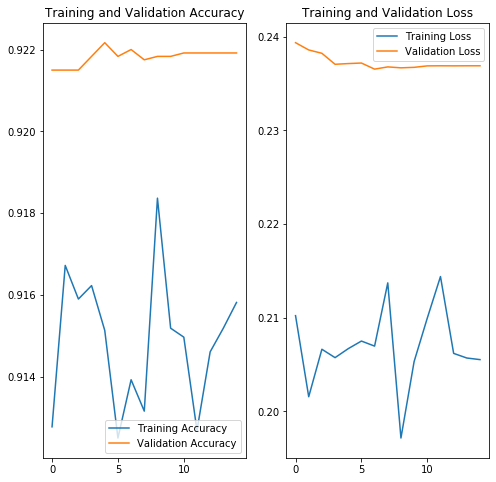

In [35]:
def plot_accurary_and_loss(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('images/{}.png'.format(name))
    plt.show()
plot_accurary_and_loss(history, 'dropout_binary_{}'.format(model_ts))